backpropagation and calculus chain rule are not tied to tensors. tensors are used for efficiency to take advantage of the parralelism in computers. it's not helpful to start learning neural networks with tensors

"micrograd is all you need to train neural networks, everything else is just efficiency"

only two files in micrograd, the actual engine (which doesn't know anything about neural nets), and the entire "neural nets library"

the actual autograd backpropogation engine that you gives you the power of neural networks is literally 100 lines of code of very simple python

"the nn library is basically a joke"
- define what is a neuron
- define what is a layer of neurons
- define what is a multi layer perceptron (a sequence of layers of neurons)
(50 lines of code)

In [116]:
# basic imports that he copy pastes in every jupyter notebook always
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [41]:
def f(x):
  return 3*x**2 - 4*x + 5

this function enters a single scalar x and returns a single scalar y

In [42]:
f(3.0)

20.0

"we can also plot this function to get a sense of its shape"

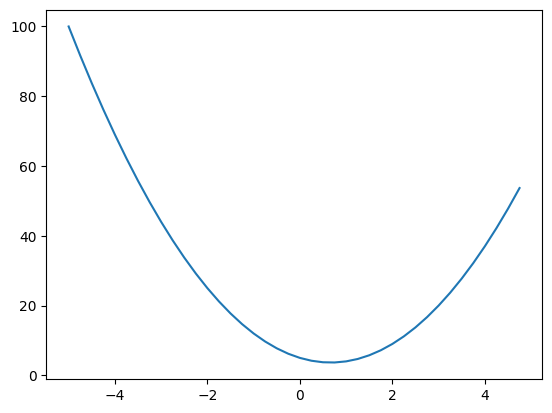

In [43]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Just simply getting the returns of the x's into the function and plotting each x and y pair on the graph

"no one in neural networks actually derives the derivative of the neural net, it would be 10,000 terms long"

In [44]:
h = 0.000001
x = 2/3
(f(x + h) - f(x)) / h

2.999378523327323e-06

"if you nudge x by h, how does the slope change/respond?"

In [45]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [46]:
h = 0.001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 3.997
slope -3.0000000000001137


by bumping a positively, and because b is negative, we are adding less to d, so the slope d2-d1 will be negative

In [47]:
h = 0.001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 4.002
slope 1.9999999999997797


by bumping b positively, and because a is positive, we'll be adding more to d, meaning slope d2-d2 will be positive

In [48]:
h = 0.001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 4.0009999999999994
slope 0.9999999999994458


by bumping c positively, and because a*b is negative, we'll be adding more to d, meaning slope d2-d2 will be positive. it will also be bumped by the exact amount that was added to c. (meaning it's slope is 1)

Neural networks are massive mathematical expressions, so we need some data structures that can mantain these expressions.

In [49]:
class Value:

  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"

a = Value(2.0)
b = Value(-3.0)
a, b

(Value(data=2.0), Value(data=-3.0))

Python will internally use the "repr" function to return when the object is put in a print or return statements. we can hijack it and return what we want.

In [50]:
class Value:

  def __init__(self, data):
    self.data = data

  # def __repr__(self):
  #   return f"Value(data={self.data})"

a = Value(2.0)
a

without repr specified all you get is an ugly pointer type expression

if we try to add a + b we'll get an error bc python doesn't know how to add two "Value" objects.

In [51]:
a + b

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

In [52]:
class Value:

  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"

  # this wraps the addition of their data in a new value object
  def __add__(self, other):
    out = Value(self.data + other.data)
    return out

a = Value(2.0)
b = Value(-3.0)
a + b

Value(data=-1.0)

you have to use the special double underscore methods to define these operators for these objects

In [53]:
# if we do
a + b
# python will now internally call
a.__add__(b)

Value(data=-1.0)

fascinating. so numbers and string "objects" all should have __add__ defined in their class definitions (if they have them)

In [54]:
class Value:

  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data)
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data)
    return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

a*b, a*b + c
# (a.__mul__(b)).__add__(c)

(Value(data=-6.0), Value(data=4.0))

In [55]:
# creating the connected tissue of the object

class Value:

  # new variable called children, by default an empty tumple if not set as anything
  def __init__(self, data, _children=()):
    self.data = data
    # children is put into a set (he believes he did it for efficiency sake)
    self._prev = set(_children)

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other))
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other))
    return out

In [56]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b + c
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [57]:
# now we know what values created this value, but we don't know
# what operation created this value

class Value:

  # new variable called _op, by default an empty string
  def __init__(self, data, _children=(), _op=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b + c
d._op

'+'

In [58]:
x = Value(8)
y = Value(19)
z = Value(73)

result = x * z * x + y + y * y
result._prev, result._op

({Value(data=361), Value(data=4691)}, '+')

In [59]:
!pip3 install graphviz

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [60]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label = "{ data %.4f }" % (n.data, ), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=str(id(n)) + n._op, label=n._op)
            # and connect this node to it
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

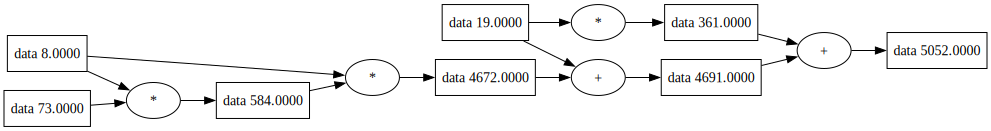

In [61]:
draw_dot(result)

In [62]:
result

Value(data=5052)

In [63]:
# adding a label variable to the value so it can be kept tracked of across the visualization

class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'

In [64]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # print the label, data, and grad of each node, .4f means format to 4 decimal places
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [65]:
draw_dot(d)

AttributeError: 'Value' object has no attribute 'grad'

In [66]:
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [67]:
draw_dot(L)

AttributeError: 'Value' object has no attribute 'grad'

so far: multiple inputs (a,b,c,f) going into a mathematical expression with a single output L. This is a representation of a forward pass.

Next we'll run backpropagation. We'll start at the end and calculate the gradient along all of the intermediate values. For every single value, we're going to compute the derivative of that "node" with respect to L (the final output)

In neural networks, you would be very interested in what the derivative of the loss function (L) is to each of the weights in the neural network. "How those weights are impacting the output."

Usually we will not want or use the derivative of the loss function with respect to data because the data is fixed. but the weights will be iterated on using the gradient information.

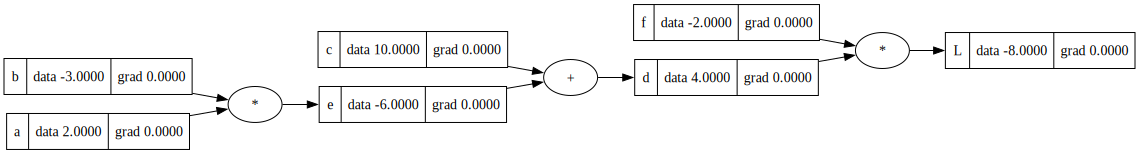

In [68]:
# creating a variable that maintains the derivative of L with respect to that Value, self.grad

class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    # 0 means no effect
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
draw_dot(L)

In [69]:
# see first hand how L will be impacted by the gradient of a node when the node is changed by h (infinitesimally small value)

def lol():

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  # a.data += h
  b = Value(-3.0, label='b')
  # b.data += h
  c = Value(10.0, label='c')
  # c.data += h
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  # d.data += h
  f = Value(-2.0, label='f')
  # f.data += h
  L = d * f; L.label = 'L'
  L2 = L.data
  # L2 = L.data + h

  print((L2 - L1)/h)

lol()

0.0


"Basic Concept: Change

- Imagine you're walking on a straight path. If you take one step forward, you've made a small change in your position.
- In math, we often want to measure how things change. This could be how a position changes, how a temperature changes, or in more complex scenarios, how one value changes when another value changes.

Introducing Functions

- A function is like a machine that takes an input and gives an output. For example, a simple function could be "multiply by 2". If you put in 3, you get out 6.
- The code you provided is creating a more complex function, but the idea is the same - it takes some inputs (a, b, c, f) and produces an output (L).

The Idea of a Derivative

- Now, imagine you want to know how much the output changes when you make a tiny change to the input. This is essentially what a derivative measures.
- In your code, L1 is the original output of the function, and L2 is the output when we make a tiny change (h) to the function.

The Calculation: (L2 - L1) / h

- (L2 - L1) measures how much the output changed. It's like measuring the distance between where you were and where you are after taking a small step.
- Dividing by h (which is a very small number) is like asking, "If I made this change h times bigger, how much would the output change?"
This division by h is what we call "normalizing". It allows us to compare changes fairly, regardless of how big or small our step (h) was.

Rise Over Run
- "Rise over run" is a way to measure the steepness of a line.
- "Rise" is how much you go up (or down)
"Run" is how much you go across

In our case:
- The "rise" is (L2 - L1), how much the output changed
- The "run" is h, our small step
So (L2 - L1) / h is measuring the "steepness" of our function at that point.

Connecting to Calculus
- In calculus, the derivative is defined as the limit of this "rise over run" calculation as h gets infinitely small.
- By using a very small h (0.001 in your code), we're approximating this limit, giving us a good estimate of the derivative.

This method of calculating the derivative is known as the "finite difference method". It's an approximation, but it's often good enough for practical purposes and it's much easier to understand and implement than the formal calculus definitions."

### "I definitely am making the right decision to get better at math" by J.D.

L = d * f

dL/dd =? f

(f(x+h)-f(x))/h

((d+h)*f - d*f)/h

(d*f + h*f - d*f) / h

(h*f)/h

f

In [70]:
L.grad = 1.0
d.grad = f.data
f.grad = d.data

"if you understand the gradient for c then you understand all of backpropagation and all of training of neural nets"

"how is L sensitive to c? if we wiggle c, how does that impact L through d?"

dd / dc ? 1.0

d = c + e

definition of a derivative:
(f(x+h) - f(x)) / h

((c+h + e) - (c +e))/h

(c + h + e - c - e)/h

h/h

1.0

dd / dc = 1.0

dd / de = 1.0

d = c + e

"the derivative of a sum expression is very simple"

so we know how d impacts L and we know how c impacts d, how do we put those together?

"and the answer of course is the chain rule of calculus"

"If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 x 4 = 8 times as fast as the man."

WANT:

dL / dc

KNOW:

dL / dd
dd / dc

dL / dc = (dL / dd) * (dd / dc)

"a plus node just routes the gradient because it is always 1.0"

and any gradient x 1.0 will just be the same as it was before

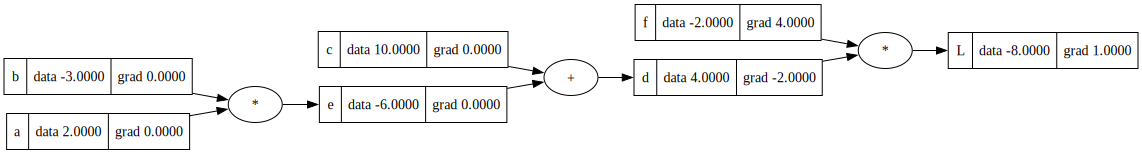

In [71]:
draw_dot(L)

In [72]:
a.grad = -2.0 * -3.0

# We can prove this because the gradient of a with respect to e is -3.0
# (because it is a multiply operation and that means the gradient is the data of the other value in the mul which in this case is b)
#
# and * -2.0 because the gradient of e with respect to L is -2.0 (because it is a + operation and that means it is just routing the grad of d) (if it routes forwards without change then it by definition routes backwards without change)

In [73]:
e.grad = -2.0
c.grad = -2.0
b.grad = -2.0 * 2.0 # this is because it is chain ruling and instead of -3.0 (which is b's data) it uses 2.0 (a's data)

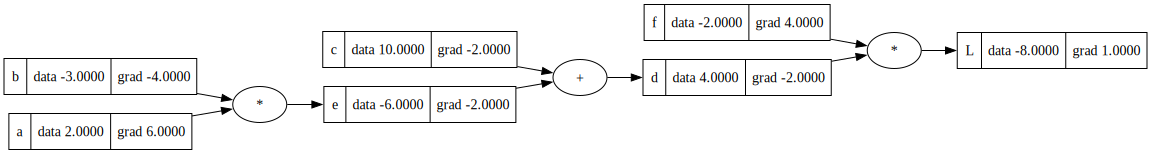

In [74]:
draw_dot(L)

"So all that backpropagation is is a recursive application of chain rule backwards through the computational graph"

I think that "leaf nodes" refers to nodes that are inputted by the user and not calculated by some operation between nodes

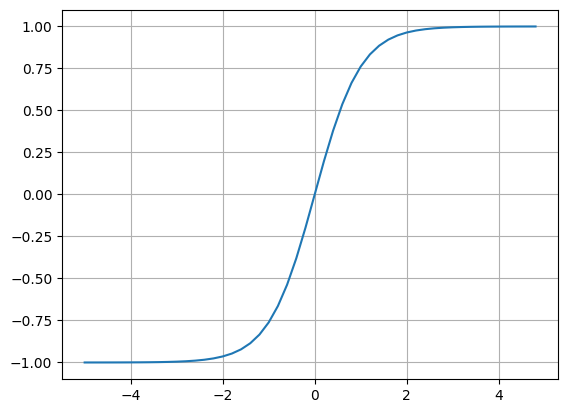

In [75]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid(); 


A mathematical representation of a neuron:

![](images/lesson1/math_neuron_diagram.png)

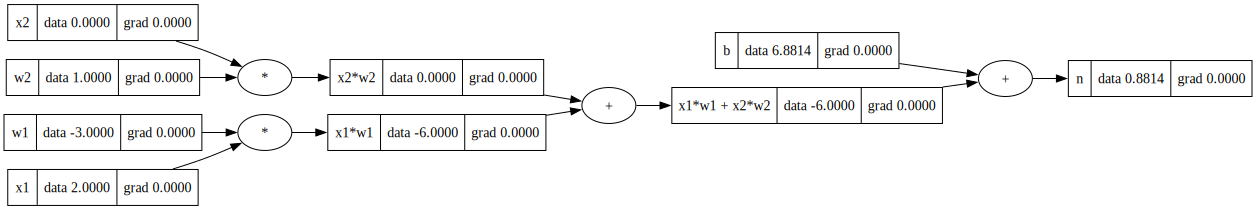

In [76]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# doing everything in small granular steps so that there's pointers all along the way
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# this n is the sum inside of the 'cell body' of the neuron
n = x1w1x2w2 + b; n. label = 'n'

draw_dot(n)

tanh definition:

![](images/lesson1/tanh_wikipedia.png)

In [77]:
# creating the tanh function:
# we don't always need to break operations down into their most atomic pieces, (like + and *)
# we can create a function at any arbitrary abstraction
# the only thing that matters is that we know how to correctly differentiate between the input and the output so that we can
# always know the correct gradient during backpropagation

class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    # Single-element Tuple: The comma after self in (self, ) is crucial. It creates a single-element tuple containing self. Without the comma, it would just be parentheses around self, which doesn't create a tuple.
    out = Value(t, (self, ), 'tanh')
    return out

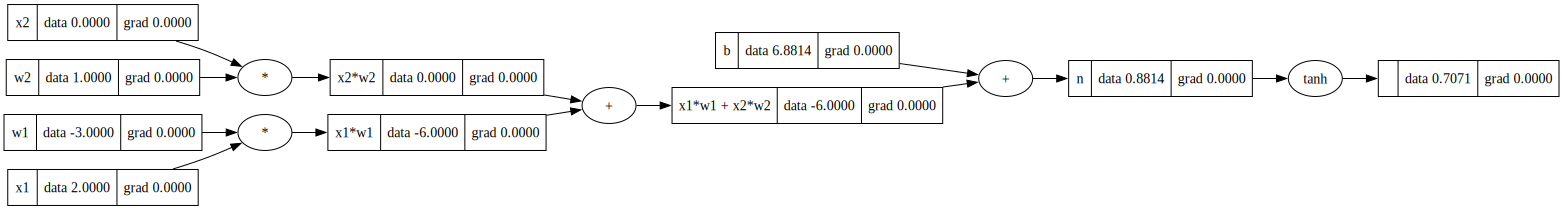

In [78]:
n = x1w1x2w2 + b; n. label = 'n'
o = n.tanh()
draw_dot(o)

In [79]:
o.grad = 1.0

o = tanh(n)

do/dn = 1 - tanh(n)^2 = 1 - o^2

In [80]:
1 - o.data**2

0.4999999999999999

In [81]:
n.grad = 0.5

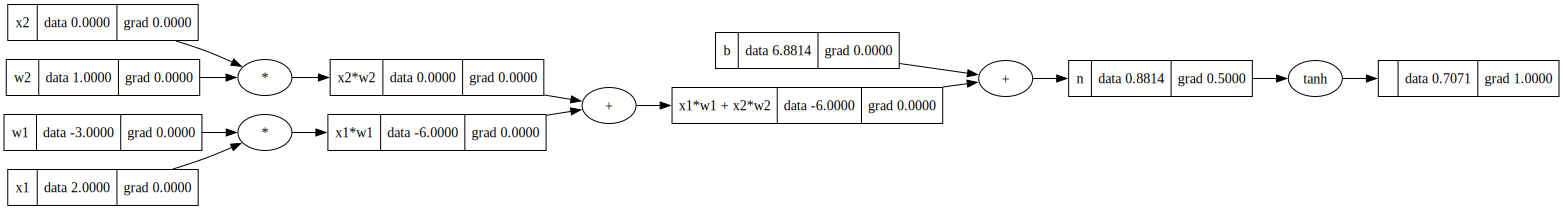

In [82]:
draw_dot(o)

In [83]:
# since a plus node is just a distributor/router of the gradient
b.grad = 0.5
x1w1x2w2.grad = 0.5

# another '+' node
x2w2.grad = 0.5
x1w1.grad = 0.5

# a '*' node
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

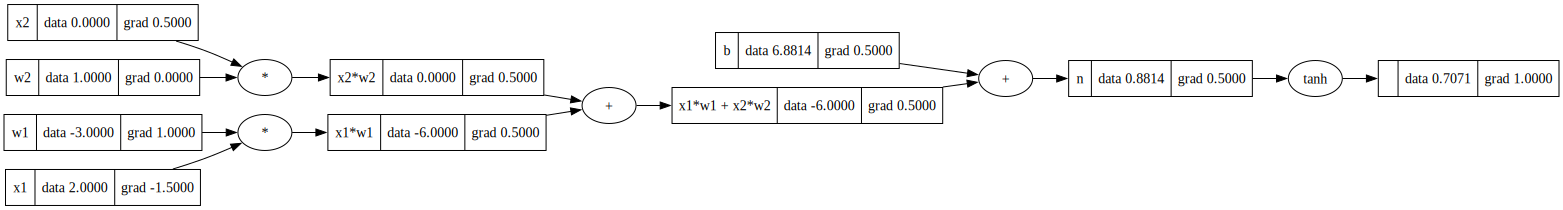

In [84]:
draw_dot(o)

"doing backpropagation manually is obviously ridiculous, so we are now going to put an end to this suffering."

In [85]:
# creating the _backward function:

class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    # it is by default initialized as a function that doesn't do anything
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    # we'll want to set the _backward value of out to be: the function that propagates the gradient
    # chain rule = local derivative multiplied by the output derivative
    def _backward():
      # this is the same as routing the gradient
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      # this is how we've been calculating a mul operations derivatives
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad

    out._backward =_backward

    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      # so if you think about it, the Value object that is output when tanh is called will now have a function called ._backward that has stored a pointer to this object
      # in o = n.tanh(), o._backward will specifically be referring to n when it calls _backward()
      # it will look something like n.grad = (1 - (math.exp(2*x) - 1)/(math.exp(2*x) + 1)**2) * o.grad
      # and in that way n's grad will be set
      self.grad = (1 - t**2) * out.grad
    out._backward =_backward

    return out

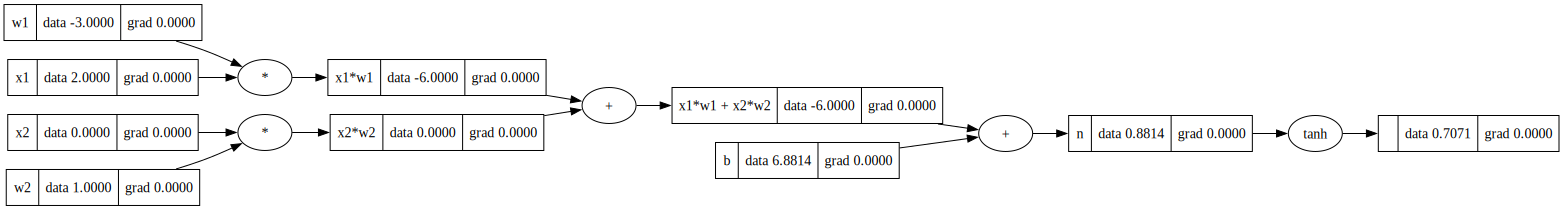

In [86]:
# making sure all of the grad's are at 0 again

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# doing everything in small granular steps so that there's pointers all along the way
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# this n is the sum inside of the 'cell body' of the neuron
n = x1w1x2w2 + b; n. label = 'n'

o = n.tanh()

draw_dot(o)

In [87]:
# bc the grad is initialized at 0, we need to set it to 1.0 as a base case
o.grad = 1.0
o._backward()
o.grad, n.grad

(1.0, 0.4999999999999999)

In [88]:
n._backward()
o.grad, n.grad, b.grad, x1w1x2w2.grad

(1.0, 0.4999999999999999, 0.4999999999999999, 0.4999999999999999)

In [89]:
# this does nothing because b is a leaf node, no mathematical operation was done to create it, and it doesn't have a backward function stored
b._backward()
o.grad, n.grad, b.grad, x1w1x2w2.grad, x1w1.grad, x2w2.grad

(1.0, 0.4999999999999999, 0.4999999999999999, 0.4999999999999999, 0.0, 0.0)

In [90]:
x1w1x2w2._backward()
o.grad, n.grad, b.grad, x1w1x2w2.grad, x1w1.grad, x2w2.grad

(1.0,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999)

In [91]:
x1w1._backward()
x2w2._backward()
o.grad, n.grad, b.grad, x1w1x2w2.grad, x1w1.grad, x2w2.grad, x1.grad, w1.grad, x2.grad, w2.grad

(1.0,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 -1.4999999999999996,
 0.9999999999999998,
 0.4999999999999999,
 0.0)

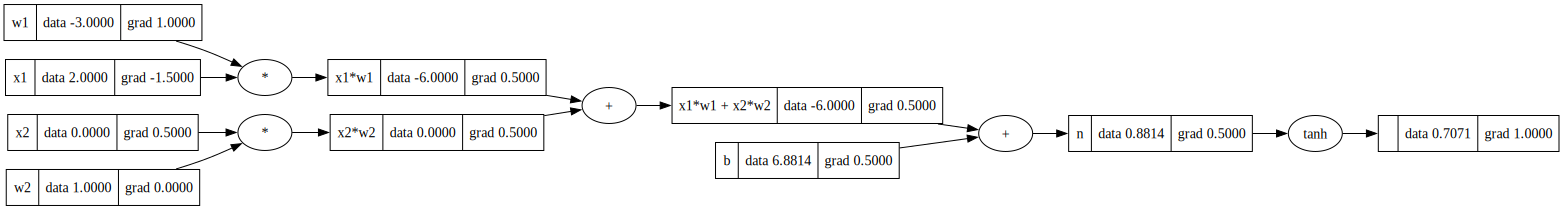

In [92]:
draw_dot(o)

now we have one last piece to get rid of, which is us calling underscore _backward manually

topological sort:
(laying out all the edges in a graph from left to right)

![](images/lesson1/topo_sort.png)

In [93]:
# this function guarantees that 'o' (the root node passed in) is only going to be added to the list once all of it's children are in the list
# and the same is true for every node in the list, so it will effectively start at the right and go through the entire computational graph leftwards, until it reaches the end
# and then start adding children to the list from left to right
# it's definitely an eye opening way to use global scope by pairing it with recursion

topo = []
visited = set ()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

this creates an ordered list where _backward can be called from right to left and it will work how we want it to

In [94]:
o.grad = 1

In [95]:
for node in reversed(topo):
    node._backward()

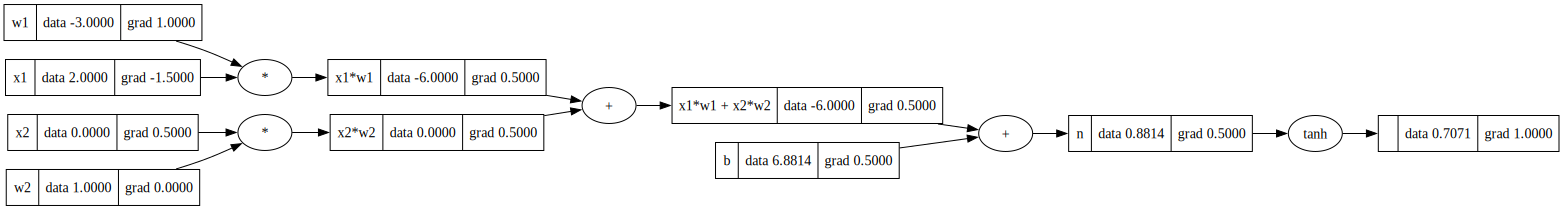

In [96]:
draw_dot(o)

In [97]:
# adding our new backprop function to this class so that it's not just lying around

class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward =_backward

    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward =_backward

    return out
  
  #here
  def backward(self):
    topo = []
    visited = set ()

    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
        node._backward()


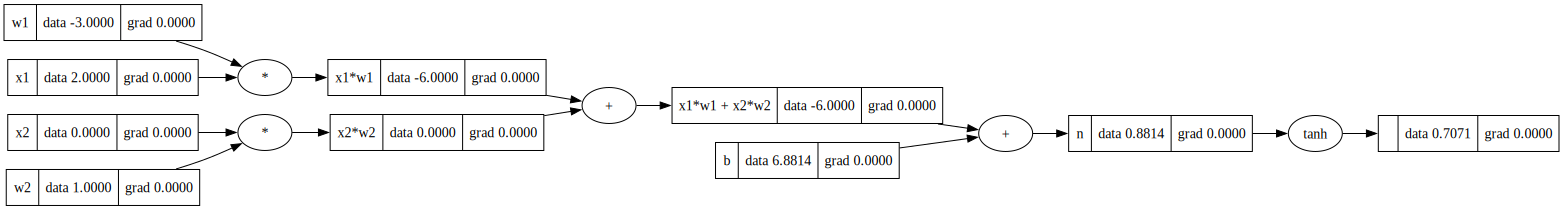

In [98]:
# making sure all of the grad's are at 0 again

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# doing everything in small granular steps so that there's pointers all along the way
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# this n is the sum inside of the 'cell body' of the neuron
n = x1w1x2w2 + b; n. label = 'n'

o = n.tanh()

draw_dot(o)

In [99]:
o.backward()

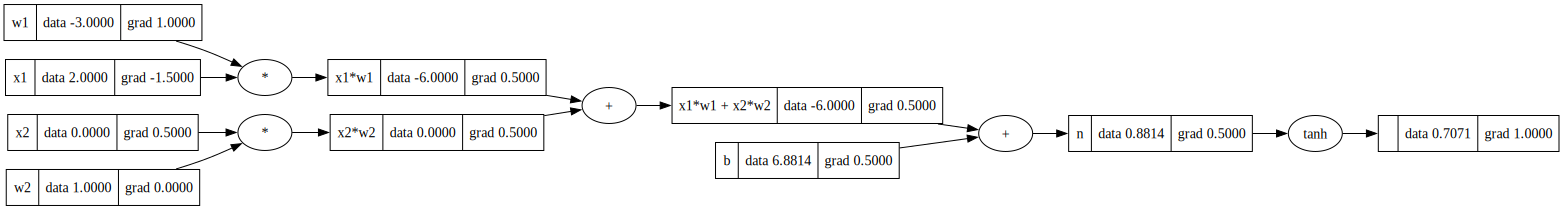

In [100]:
draw_dot(o)

apparently there's a huge bug where adding a + a would make the gradient wrong so we have to change the = of every _backward() in the Value class to +=

I did it already but I'm not going to write copy paste

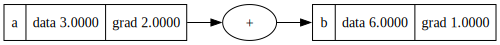

In [101]:
# to show the bug is fixed
a = Value(3.0, label='a')
b= a + a; b.label = 'b'

b.backward()
draw_dot(b)

In [271]:
# making it so we can add actual integers and floats to Value objects
# also creating an exp function
# also creating the division function as truediv (x^-1)
# and adding subtraction

class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out
  
  def __radd__(self, other): # other + self
     # this calls __add__ on self which creates the same behaviour we want
     return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward =_backward

    return out
  
  #here
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value (self.data**other, (self, ), f'**{other}')

    def _backward():
       self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
     # this calls __mul__ on self which creates the same behaviour we want, very clever
     return self * other
  
  # here
  def __truediv__(self, other): # self / other
    return self * other**-1
  
  # here
  def __neg__(self): # -self
    return self * -1
  
  # and here
  def __sub__(self, other): # self - other
    return self + (-other)
  
  # adding these in case he doesn't get to it
  def __rsub__(self, other): # other - self
    return other + (-self)
  
  # ^
  def __rtruediv__(self, other): # other / self
    return other * self**-1
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward =_backward

    return out
  
  def relu(self):
    out = Value(0 if self.data < 0 else self.data, (self, ), 'ReLU')

    def _backward():
       self.grad += (out.data > 0) * out.grad
    out._backward = _backward

    return out
  
  #here
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
        self.grad += out.data * out.grad
    out._backward = _backward

    return out
  
  def backward(self):
    topo = []
    visited = set ()

    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
        node._backward()


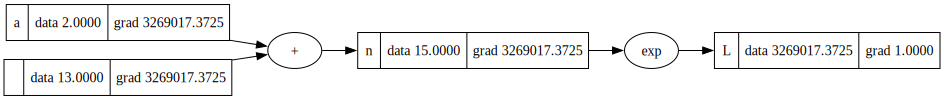

In [103]:
a = Value(2.0); a.label = 'a'
# a + 1, a * 2
# 1 + a, 2 * a #these don't work
n = 13 + a; n.label = 'n'
# n.backward()
L = n.exp(); L.label = 'L'
L.backward()
draw_dot(L)

In [104]:
b = Value(5.0); b.label = 'b'
b.exp()

Value(data=148.4131591025766)

division can actually be reshuffled as:

a / b

a * (1/b)

a * (b^-1)

x**k for some constant k (int or float)

In [113]:
e = Value(5.0); b.label = 'b'
1 - e
1 / e
e / 3

Value(data=1.6666666666666665)

Lmao it's been an hour and i've moved forward in the video 10 mins!!

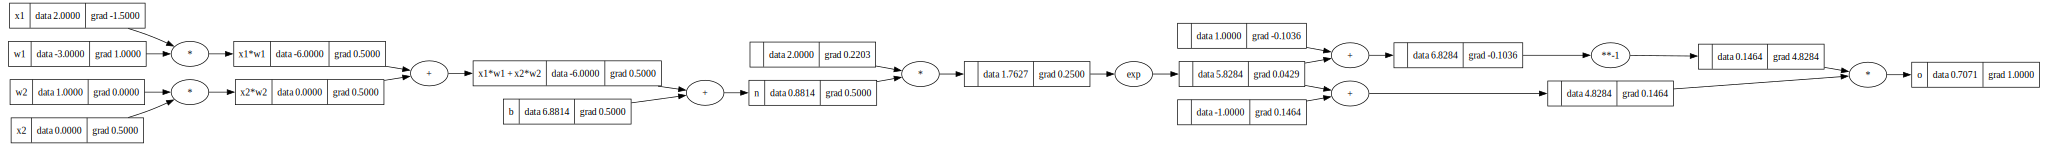

In [114]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# doing everything in small granular steps so that there's pointers all along the way
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# this n is the sum inside of the 'cell body' of the neuron
n = x1w1x2w2 + b; n. label = 'n'
# ------
e = (2*n).exp()
o = (e - 1) / (e + 1)
# -----
# o = n.tanh()
o.label = 'o'
o.backward()
draw_dot(o)

# PyTorch

In [115]:
import torch

x1 = torch.Tensor([2.0]).double()                  ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                  ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                 ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                  ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()    ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


micrograd is a scalar valued engine so we only have scalar values like 2.0

but in pytorch everything is based around tensors

tensors are just n dimensional arrays of scalars

so to replicate micrograd we're just using scalar valued tensors i.e. torch.Tensor([2.0]).double()

but in pytorch you would usually use more complicated tensors like torch.Tensor([[1, 2, 3], [4, 5, 6]])

In [116]:
torch.Tensor([[1, 2, 3], [4, 5, 6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [276]:
# defining a neuron

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    # __call__ is the function that python uses when you put parantheses beside an object, like Neuron(x)
    def __call__(self, x):
        # w * x + b
        # in python zip takes two iterates and creates a new iterator that iterates over the tuples of their corresponding entries
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        # out = act.relu()
        
        return out

    def parameters(self):
        return self.w + [self.b]

In [173]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.9971337728975177)

In [174]:
# defining a layer of neurons

class Layer:
    # how many inputs going into the layer, how many neurons do you want in this layer
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # same as this
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params

In [175]:
n = Layer(2, 3)
n(x)

[Value(data=-0.5870720088695726),
 Value(data=0.9890204850822472),
 Value(data=-0.9989482980565654)]

In [176]:
# defining a multi layer perceptron

class MLP:
    # how many inputs in the input layer, how many inputs per layer, including the output layer (i'm guessing you can have more than one output if you really want)
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

multi layer perceptron(MLP)

![](images/lesson1/multi_layer_perceptron.png)

In [177]:
# recreating the picture

# 3 inputs
x = [2.0, 3.0, -1.0]
# 2 layers with 4 neurons, 1 output
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.5448097318391738)

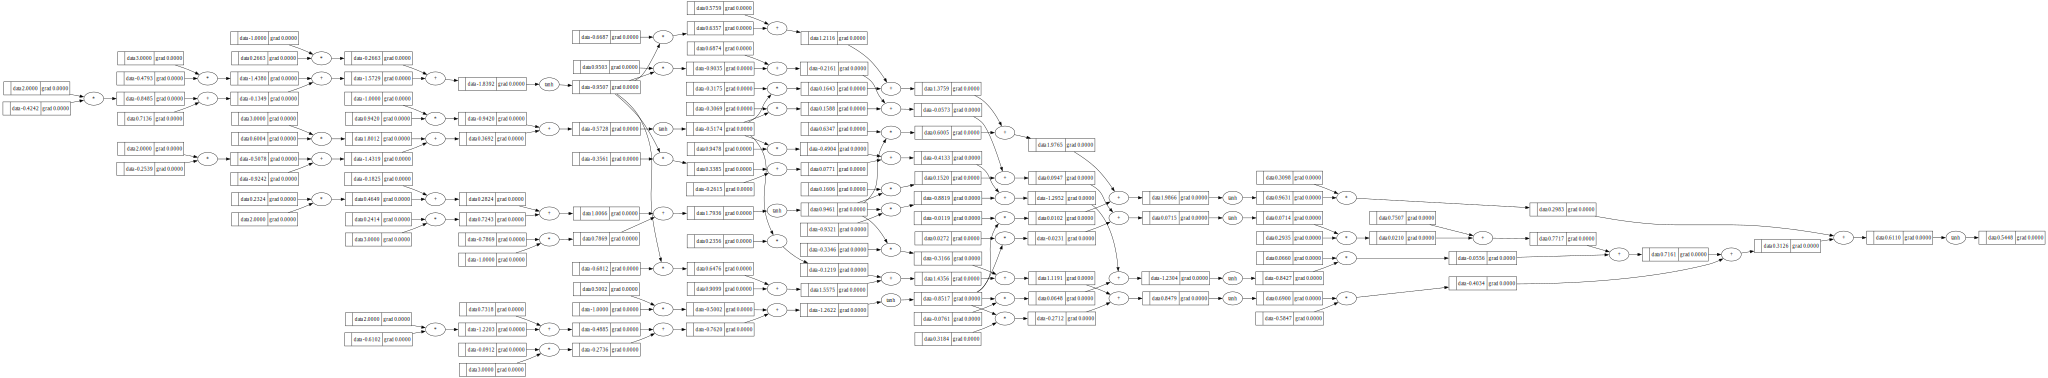

In [178]:
draw_dot(n(x))

In [244]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
# we want the neural net to output each y when fed each correspond x[] ("very simple" binary classifier neural net)
# to see what the neural net currently thinks about these examples, we can get it's predictions with:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9999999999914314),
 Value(data=-1.0),
 Value(data=-1.0),
 Value(data=0.99999999998769)]

so how do we tune the weights so that we can push these outputs towards our desired ones?

the trick in neural networks is to calculate a single number than can measure the total performance of the neural net

this number is called the loss

when the nn is performing badly the loss will be high, and we'll want to minimize the loss

In [187]:
# mean squared loss
'without squaring',[(yout - ygt) for ygt, yout in zip(ys, ypred)], 'with squaring',[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
# ygt means y ground truth, the ground truth  is the one that we want it to be
# yout is the prediction that the model actually made
# for each of those (there are 4) we are subtracting the prediction by the one we want and then we are squaring them
# this is one way to get the loss
# the loss will be 0 when it's dead accurate
# when you just subtracting them with out squaring them, you're getting the difference in between what you wanted and what you got, the higher the difference the farther away you were
# when you square them, you are making sure that the number is positive
# instead of squaring we could also take the absolute value (main point is we need to discard the sign)
# any expression where the answer is 0 when the prediction is equal to the ground truth and there is no minus sign, works

('without squaring',
 [Value(data=-0.4551902681608262),
  Value(data=1.6959993376174838),
  Value(data=1.4153349047022032),
  Value(data=-0.31230520204457246)],
 'with squaring',
 [Value(data=0.20719818022832487),
  Value(data=2.8764137531989435),
  Value(data=2.003172892468395),
  Value(data=0.09753453922410123)])

In [181]:
# the final loss will just be the sum of all of those numbers
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.184319365119764)

In [238]:
loss.backward()

In [188]:
n.layers[0].neurons[0].w[0].grad, n.layers[0].neurons[0].w[0].data 

# we have the gradient of every single one of our neurons
# since this particular gradient is negative, it means that it's influence on the loss is "negative"
# so increasing the weight would make the loss go up (don't ask me)

(1.4912957779305662, -0.42424474675794177)

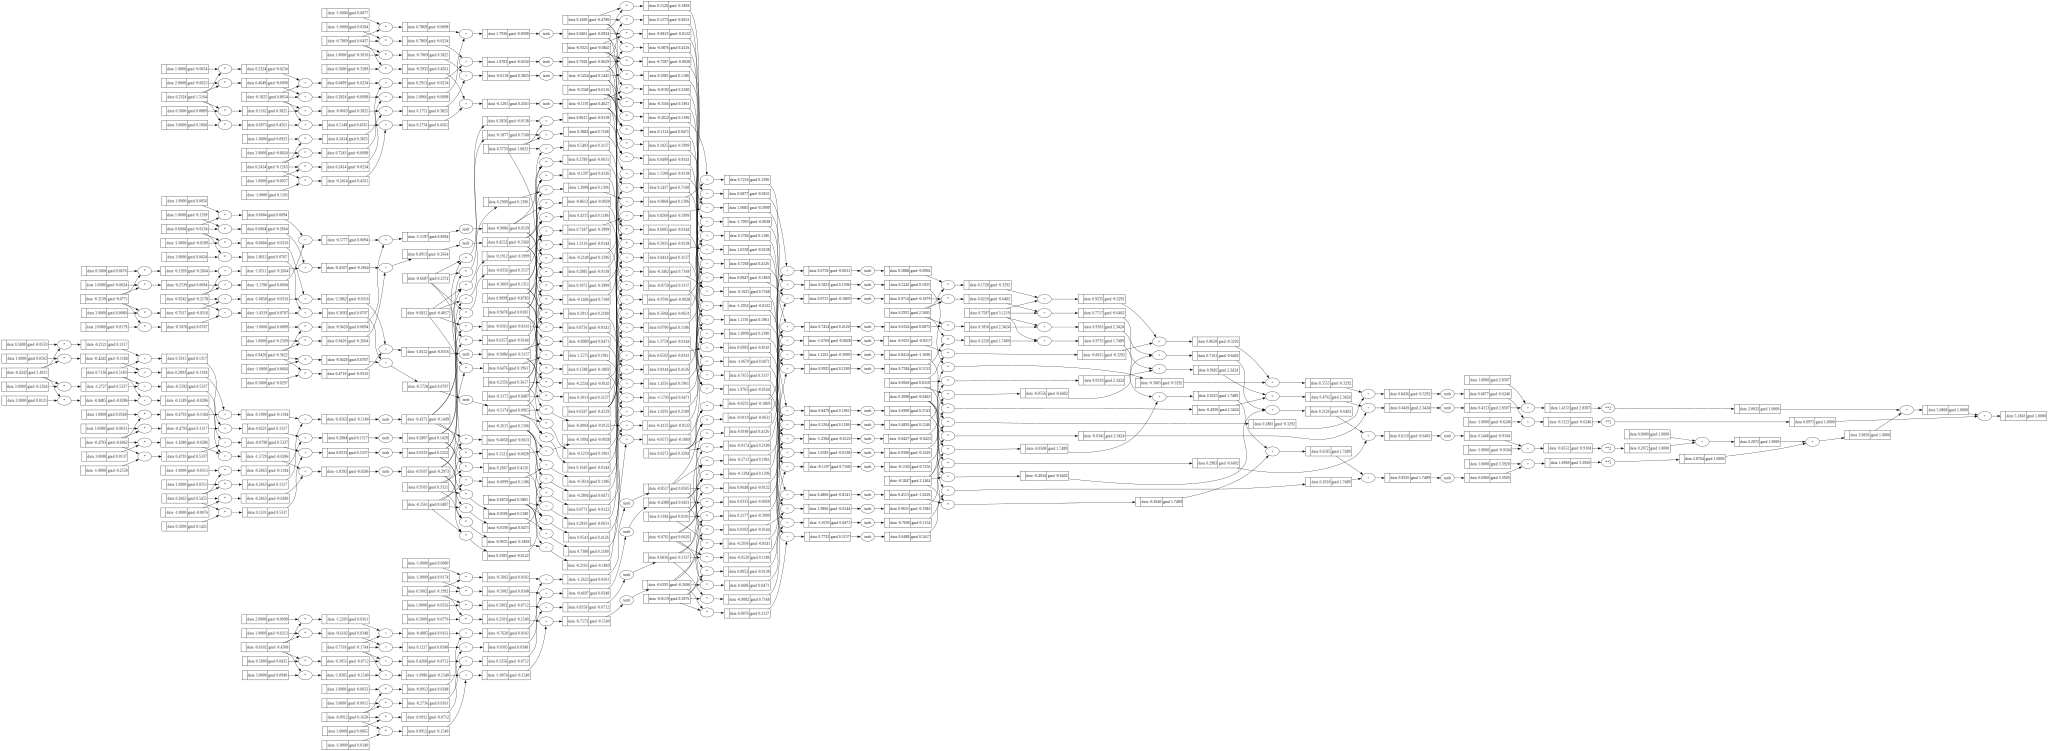

In [184]:
draw_dot(loss)

In [185]:
n.parameters()

[Value(data=-0.42424474675794177),
 Value(data=-0.47933211635782946),
 Value(data=0.2662896272148638),
 Value(data=0.7135808346134382),
 Value(data=-0.25389486032450526),
 Value(data=0.6003876995966702),
 Value(data=0.9419924853189223),
 Value(data=-0.9241531360403057),
 Value(data=0.23244242155003514),
 Value(data=0.2414263465287656),
 Value(data=-0.7869369790681215),
 Value(data=-0.18252728132934348),
 Value(data=-0.6101623345000338),
 Value(data=-0.09118895244936454),
 Value(data=0.500206882021913),
 Value(data=0.7318487344397078),
 Value(data=0.9503195495049657),
 Value(data=-0.3069084485034195),
 Value(data=0.1606223338743975),
 Value(data=0.027150696016805753),
 Value(data=0.6873909280491226),
 Value(data=-0.3560903157579991),
 Value(data=0.9478019173129526),
 Value(data=-0.9320600937741736),
 Value(data=-0.07606742415471057),
 Value(data=-0.2614760480958003),
 Value(data=-0.6811582683171531),
 Value(data=0.23555495392924097),
 Value(data=-0.3345959321375209),
 Value(data=0.31840

he keeps calling the way we use these classes as the 'api' of the library, kind of interesting

each parameter is the weight + the bias of each neuron

In [239]:
# for every parameter, we want to change it's data slightly so that it will bring the loss down
# in this example, if the data is positive, the gradient will be negative
# if the data is negative, the gradient will be positive
# so we want to multiple the gradient by -0.01 because we want to nudge the data slightly and also in the direction "away from the loss"
# negative data will become slightly more negative
# positive data will become slightly more positive
# apparently this will minimize the loss
# i think he said "the gradients we have already made the loss high, so we want to go in the opposite direction of each gradient" don't quote me on that

for p in n.parameters():
    p.data += -0.01 * p.grad

In [190]:
# the grad is the same but the data is a tiny bit changed (in this case it is smaller / lesser)
n.layers[0].neurons[0].w[0].grad, n.layers[0].neurons[0].w[0].data 

(1.4912957779305662, -0.43915770453724745)

In [241]:
# recalculating the loss
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss
ypred

[Value(data=0.9970436359882621),
 Value(data=-0.9553891881853869),
 Value(data=-0.9989810009187612),
 Value(data=0.993418021788124)]

these were the predictions the first time around:

[Value(data=0.5448097318391738),

 Value(data=0.6959993376174838),

 Value(data=0.4153349047022032),
 
 Value(data=0.6876947979554275)]

 maybe i made a mistake because the first and last got slightly lower when we wanted them to get slightly higher

 the middle two did get slightly lower though which is what we wanted

 but i mean the loss was lower?

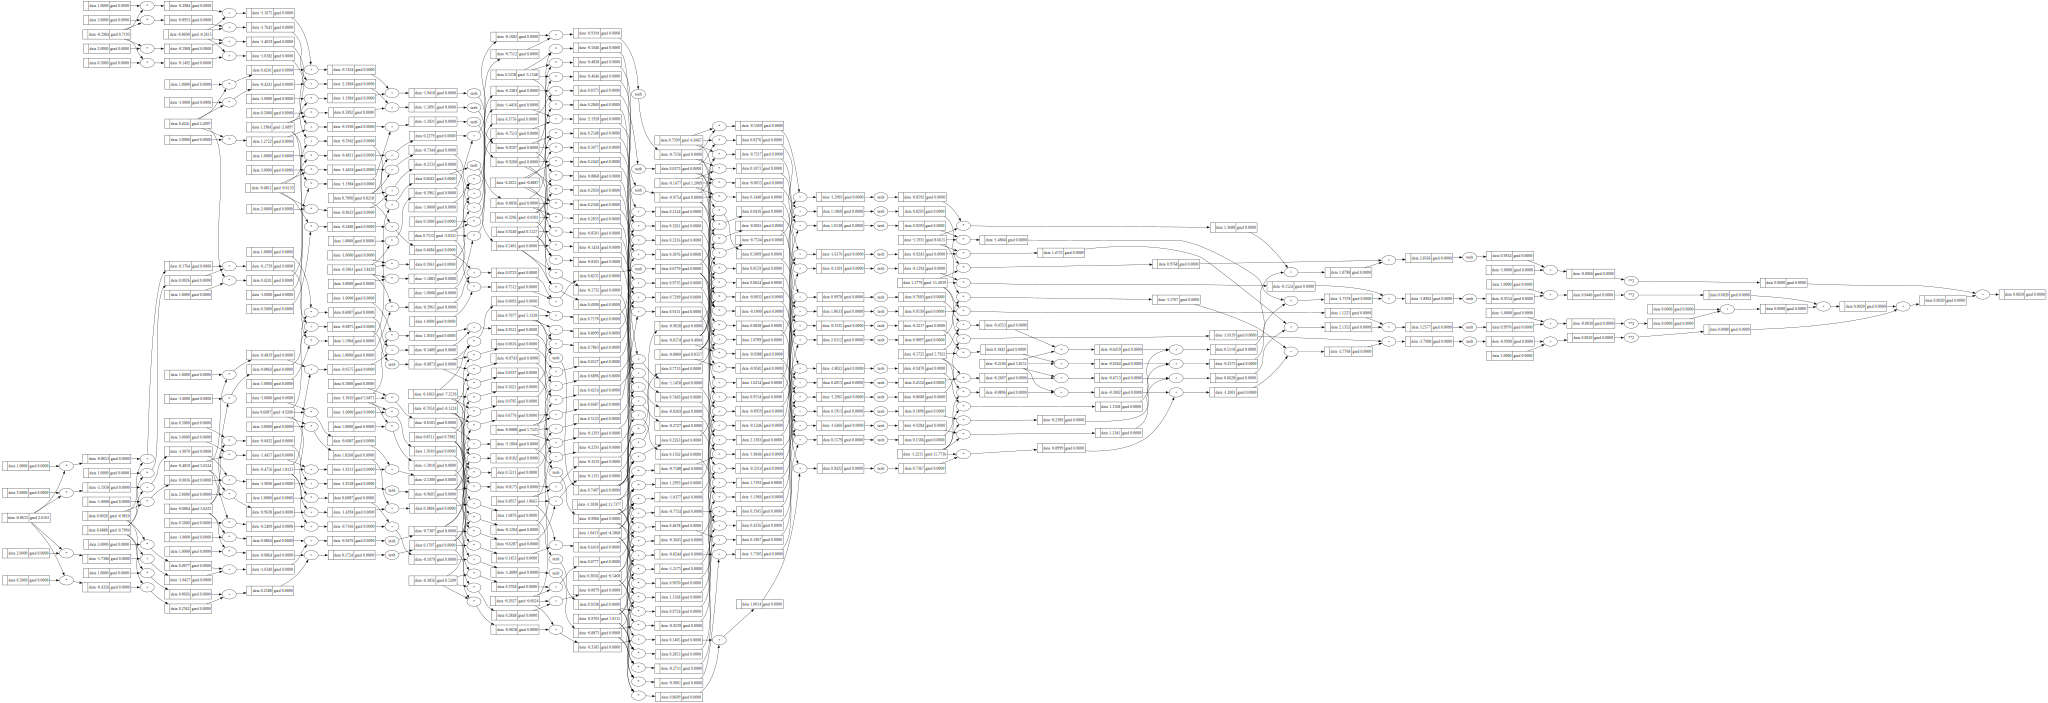

In [242]:
draw_dot(loss)

#### nvm

that's all that gradient descent is, forward pass, backward pass, update weights, forward pass, backward pass, update weights

"if you try to make the learning too fast, you can make the loss blow up"

setting the learning rate is a subtle art, if it's too low, it'll take you way too long to converge, but if it's too high, the whole thing gets unstable

In [285]:
# making the training loop more respectable

# resetting the neural network

# 3 inputs
x = [2.0, 3.0, -1.0]
# 2 layers with 4 neurons, 1 output
n = MLP(3, [4, 4, 1])

# dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# scale_factor = 5
# desire targets
ys = [1.0, -1.0, -1.0, 1.0]
# ys = [5.0, -5.0, -5.0, 5.0]

# training loop
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    # loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # backward pass
    for p in n.parameters(): # new and included zero grad
        p.grad = 0.0
    loss.backward()
    
    # updating weights
    for p in n.parameters():
        p.data += -0.1 * p.grad

    # print current step, current loss
    print(k, loss.data)

ypred

0 5.551220024321892
1 4.336090337065632
2 3.500994669401282
3 2.847419003818791
4 1.8782361597292143
5 1.087985016094549
6 1.0117482662394517
7 0.7484544543339328
8 0.12529003210614642
9 0.06552910300567161
10 0.05051184619760646
11 0.04257447406422071
12 0.03741743968452485
13 0.03367755955594377
14 0.03077544762764803
15 0.028420346614961733
16 0.026448895772639557
17 0.02476125237876526
18 0.023292240052205274
19 0.021997001656754805


[Value(data=0.9408561258638133),
 Value(data=-0.945675606625899),
 Value(data=-0.921426381025932),
 Value(data=0.9031803196928867)]

lmao! we didn't zero grad. I don't get why it matters because it was working, but  we'll add it now

my theory is that because it was such a simple operation, we only had 20 iteration each time and the learning rate was only 0.01-0.03, the model could still converge

after we started flushing them it actually converges a lot slower, so i'm guessing that not flushing meant that we weren't training the model from scratch

he confirms this

it breaks when i try to make the desired targets 5, -5, -5, and 5 and I don't know why

I think it has something to do with how tanh is the activation function, I tried using linear activation (if that even exists) and it crashed

in regards to gpt, the learning problem is to take the entire internet as a dataset, and then when given a sequence of words, the neural net has to predict the next word in the sequence

and it just turns out that the neural net trained to do this has wonderful emergent properties